# Bayesian Workflow (Police Officer’s Dilemma)

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
az.style.use("arviz-darkgrid")
SEED = 1234

Here we will analyze a dataset from experimental psychology in which a sample of 36 human participants engaged in what is called the [shooter task](http://psych.colorado.edu/~jclab/FPST.html), yielding 3600 responses and reaction times (100 from each subject). The link above gives some more information about the shooter task, but basically it is a sort of crude first-person-shooter video game in which the subject plays the role of a police officer. The subject views a variety of urban scenes, and in each round or “trial” a person or “target” appears on the screen after some random interval. This person is either Black or White (with 50% probability), and they are holding some object that is either a gun or some other object like a phone or wallet (with 50% probability). When a target appears, the subject has a very brief response window – 0.85 seconds in this particular experiment – within which to press one of two keyboard buttons indicating a “shoot” or “don’t shoot” response. Subjects receive points for correct and timely responses in each trial; subjects’ scores are penalized for incorrect reponses (i.e., shooting an unarmed person or failing to shoot an armed person) or if they don’t respond within the 0.85 response window. The goal of the task, from the subject’s perspective, is to maximize their score.

The typical findings in the shooter task are that

* Subjects are quicker to respond to armed targets than to unarmed targets, but are especially quick toward armed black targets and especially slow toward unarmed black targets.
* Subjects are more likely to shoot black targets than white targets, whether they are armed or not.

## Load and examine data

In [3]:
shooter = pd.read_csv("data/shooter.csv", na_values=".")
shooter.head(10)

subject target  trial   race object   time   response
0        1    w05     19  white  nogun  658.0    correct
1        2    b07     19  black    gun  573.0    correct
2        3    w05     19  white    gun  369.0    correct
3        4    w07     19  white    gun  495.0    correct
4        5    w15     19  white  nogun  483.0    correct
5        6    w96     19  white  nogun  786.0    correct
6        7    w13     19  white  nogun  519.0    correct
7        8    w06     19  white  nogun  567.0    correct
8        9    b14     19  black    gun  672.0  incorrect
9       10    w90     19  white    gun  457.0    correct

The design of the experiment is such that the subject, target, and object (i.e., gun vs. no gun) factors are fully crossed: each subject views each target twice, once with a gun and once without a gun.

In [4]:
pd.crosstab(shooter["subject"], [shooter["target"], shooter["object"]])

target  b01       b02       b03       b04       b05        ... w95       w96  \
object  gun nogun gun nogun gun nogun gun nogun gun nogun  ... gun nogun gun   
subject                                                    ...                 
1         1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
2         1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
3         1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
4         1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
5         1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
6         1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
7         1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
8         1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
9         1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
10        1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
11        1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
12        1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
13        1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
14        1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
15        1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
16        1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
17        1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
18        1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
19        1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
20        1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
21        1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
22        1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
23        1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
24        1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
25        1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
26        1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
27        1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
28        1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
29        1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
30        1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
31        1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
32        1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
33        1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
34        1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
35        1     1   1     1   1     1   1     1   1     1  ...   1     1   1   
36        1     1   1     1   1     1   1     1   1     1  ...   1     1   1   

target        w97       w98       w99        
object  nogun gun nogun gun nogun gun nogun  
subject                                      
1           1   1     1   1     1   1     1  
2           1   1     1   1     1   1     1  
3           1   1     1   1     1   1     1  
4           1   1     1   1     1   1     1  
5           1   1     1   1     1   1     1  
6           1   1     1   1     1   1     1  
7           1   1     1   1     1   1     1  
8           1   1     1   1     1   1     1  
9           1   1     1   1     1   1     1  
10          1   1     1   1     1   1     1  
11          1   1     1   1     1   1     1  
12          1   1     1   1     1   1     1  
13          1   1     1   1     1   1     1  
14          1   1     1   1     1   1     1  
15          1   1     1   1     1   1     1  
16          1   1     1   1     1   1     1  
17   

The response speeds on each trial are recorded given as reaction times (milliseconds per response), but here we invert them to and multiply by 1000 so that we are analyzing response rates (responses per second). There is no theoretical reason to prefer one of these metrics over the other, but it turns out that response rates tend to have nicer distributional properties than reaction times (i.e., deviate less strongly from the standard Gaussian assumptions), so response rates will be a little more convenient for us by allowing us to use some fairly standard distributional models.

In [5]:
shooter["rate"] = 1000.0 / shooter["time"]

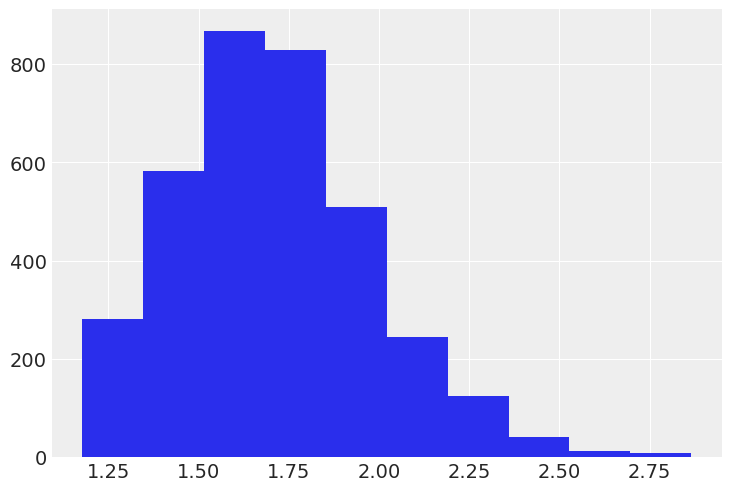

In [6]:
plt.hist(shooter["rate"].dropna());

## Fit response rate models

### Subject specific effects only

Our first model is analogous to how the data from the shooter task are usually analyzed: incorporating all subject-level sources of variability, but ignoring the sampling variability due to the sample of 50 targets. This is a Bayesian generalized linear mixed model (GLMM) with a Normal response and with intercepts and slopes that vary randomly across subjects.

Of note here is the ```S(x)``` syntax, which is from the [Formulae library](https://bambinos.github.io/formulae/) that we use to parse model formulas. This instructs Bambi to use contrast codes of -1 and +1 for the two levels of each of the common factors of ```race``` (black vs. white) and ```object``` (gun vs. no gun), so that the ```race``` and ```object``` coefficients can be interpreted as simple effects on average across the levels of the other factor (directly analogous, but not quite equivalent, to the main effects). This is the standard coding used in ANOVA.

In [7]:
subj_model = bmb.Model(
    "rate ~ S(race) * S(object) + (S(race) * S(object) | subject)", 
    shooter, 
    dropna=True
)
subj_fitted = subj_model.fit(random_seed=SEED)

Automatically removing 98/3600 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, S(race), S(object), S(race):S(object), 1|subject_sigma, 1|subject_offset, S(race)|subject_sigma, S(race)|subject_offset, S(object)|subject_sigma, S(object)|subject_offset, S(race):S(object)|subject_sigma, S(race):S(object)|subject_offset]


c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 104 seconds.


First let’s visualize the default priors that Bambi automatically decided on for each of the parameters. We do this by calling the ```.plot_priors()``` method of the ```Model``` object.

Sampling: [1|subject_sigma, Intercept, S(object), S(object)|subject_sigma, S(race), S(race):S(object), S(race):S(object)|subject_sigma, S(race)|subject_sigma, sigma]


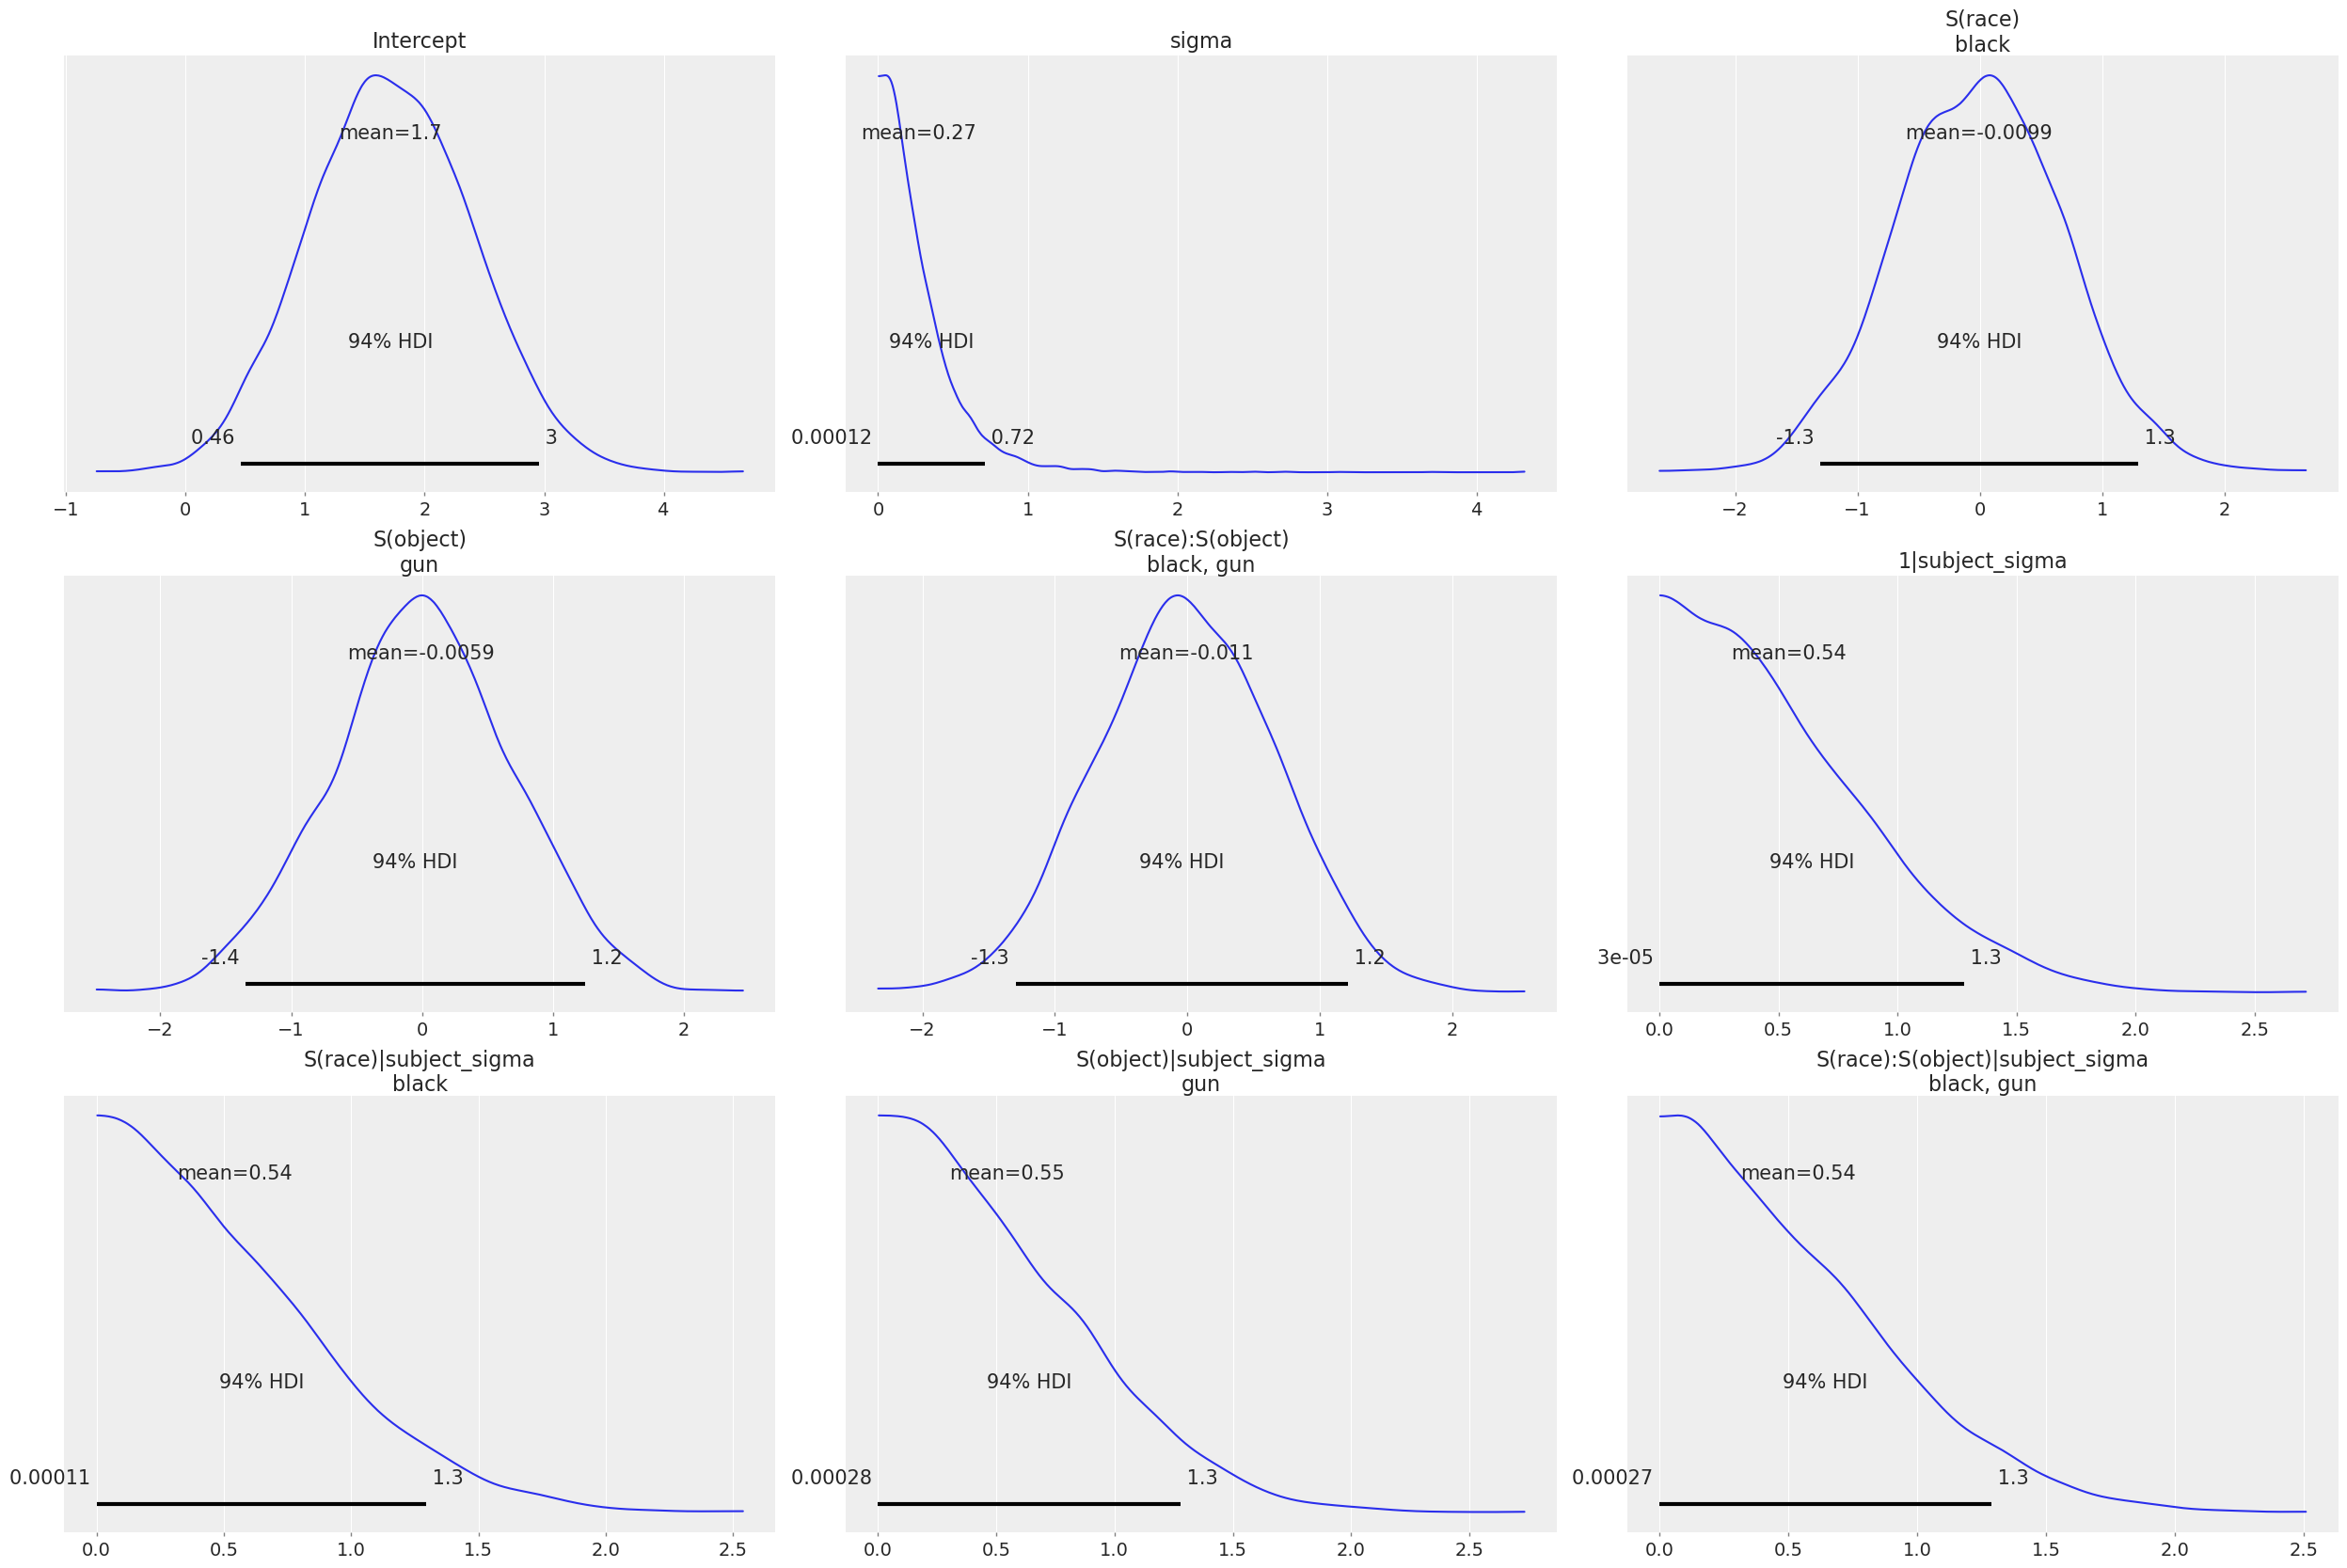

In [8]:
subj_model.plot_priors();

The priors on the common effects seem quite reasonable. Recall that because of the -1 vs +1 contrast coding, the coefficients correspond to half the difference between the two levels of each factor. So the priors on the common effects essentially say that the black vs. white and gun vs. no gun (and their interaction) response rate differences are very unlikely to be as large as a full response per second.

Now let’s visualize the model estimates. We do this by passing the ```InferenceData``` object that resulted from the```Model.fit()``` call to ```az.plot_trace()```.

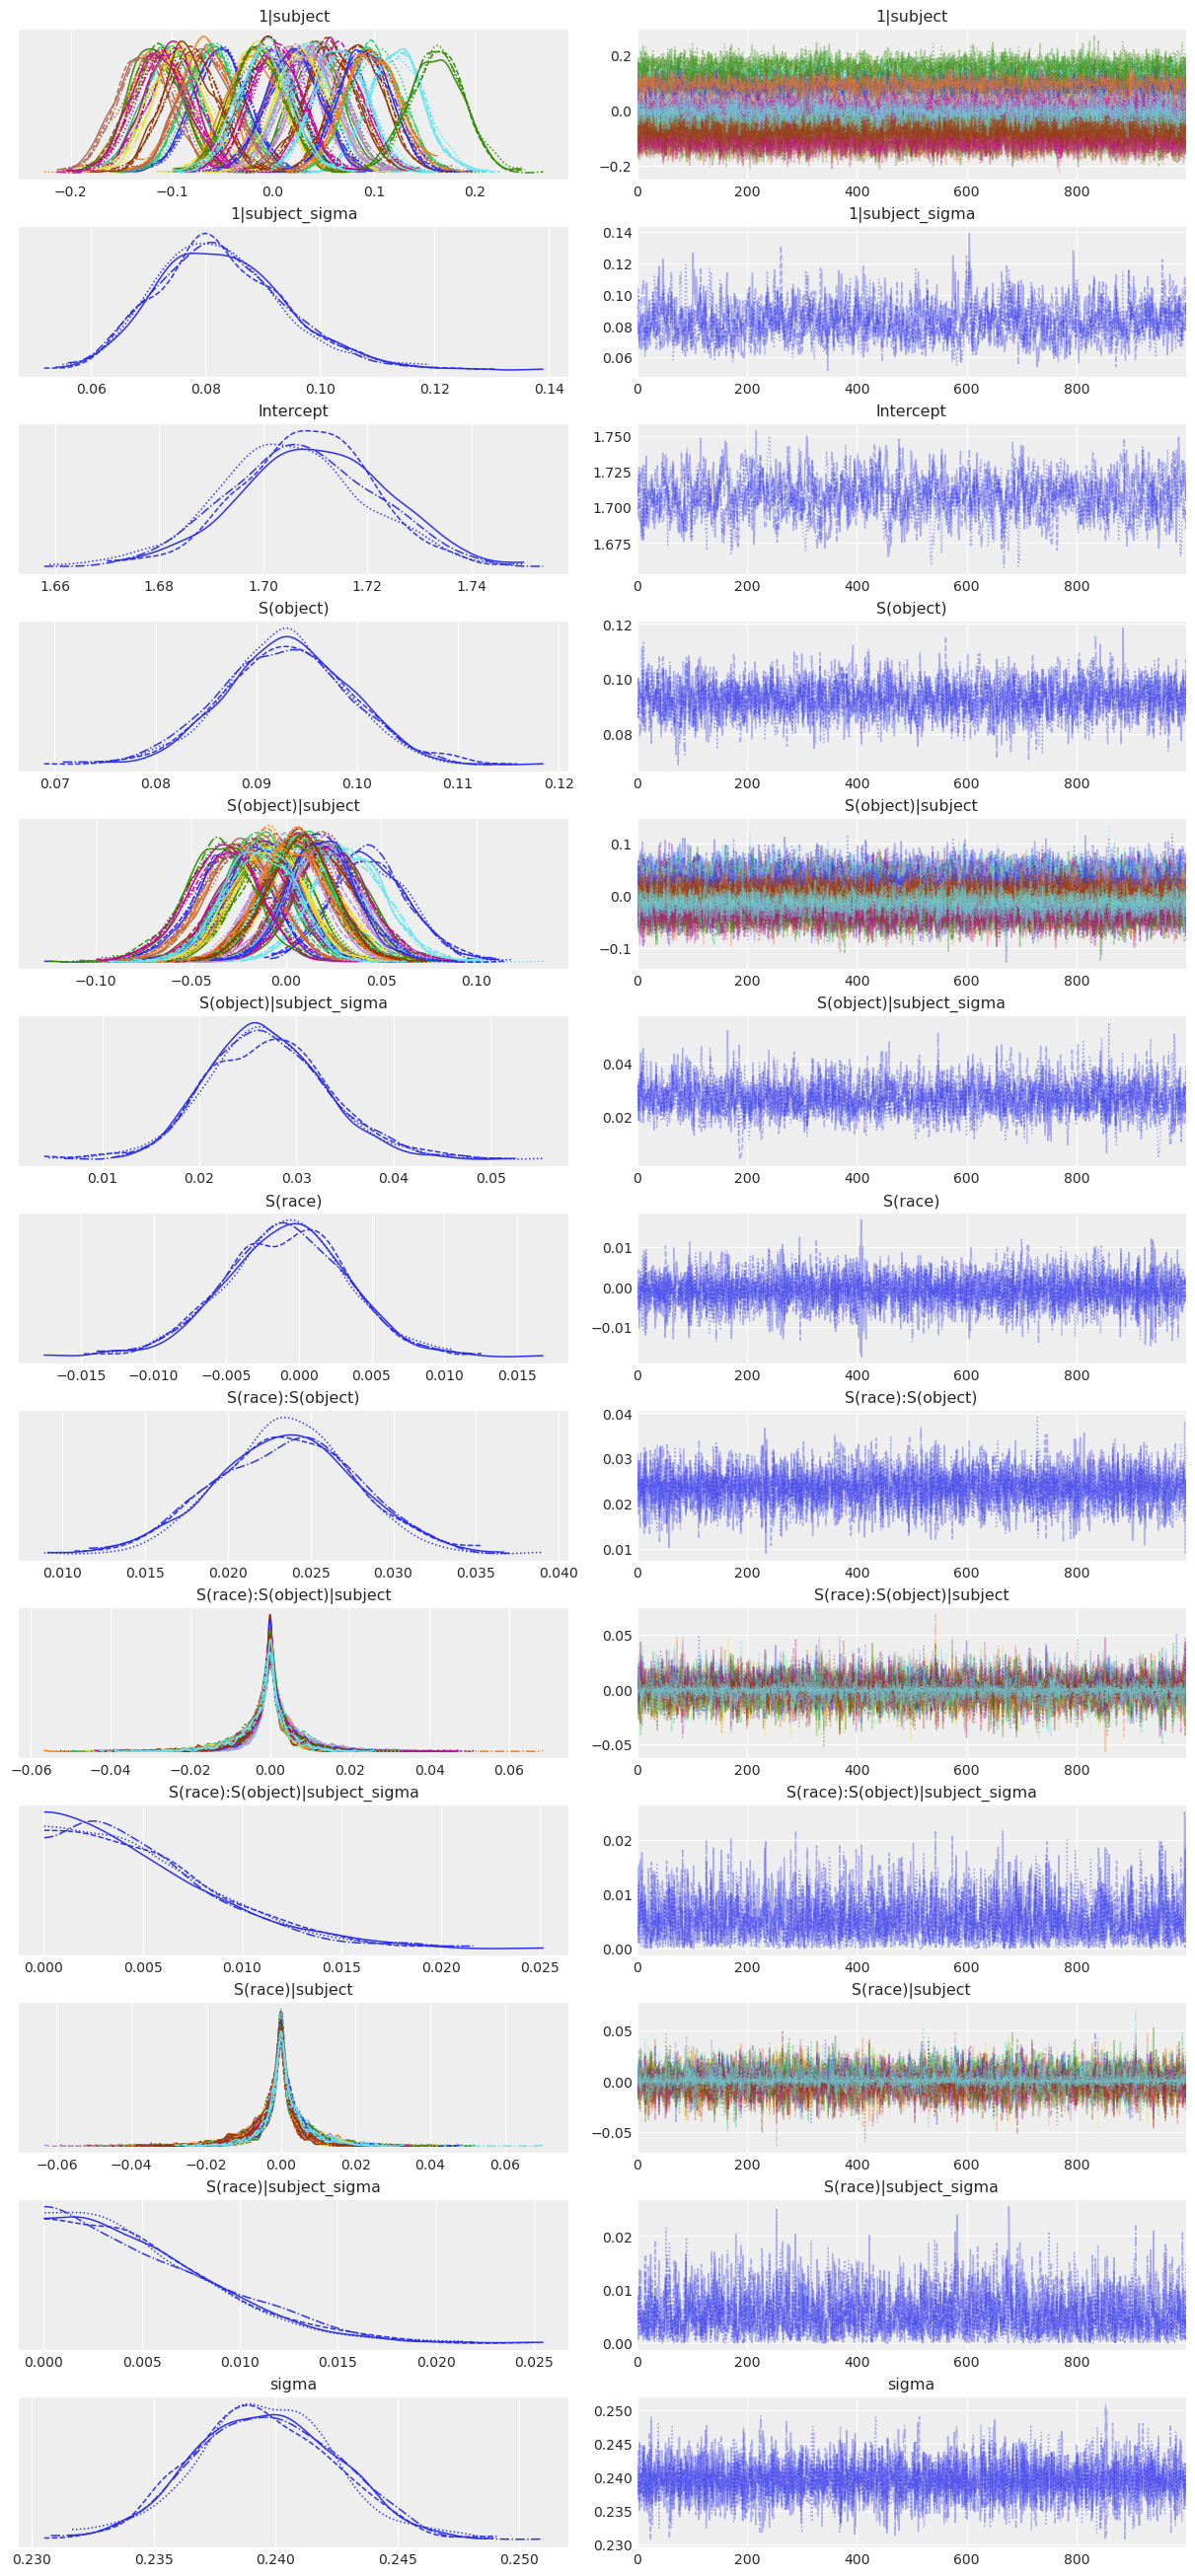

In [9]:
az.plot_trace(subj_fitted);

Each distribution in the plots above has 2 densities because we used 2 MCMC chains, so we are viewing the results of all 2 chains prior to their aggregation. The main message from the plot above is that the chains all seem to have converged well and the resulting posterior distributions all look quite reasonable. It’s a bit easier to digest all this information in a concise, tabular form, which we can get by passing the object that resulted from the ```Model.fit()``` call to ```az.summary()```.

In [10]:
az.summary(subj_fitted)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
1|subject[1]                 -0.003  0.027  -0.055    0.046      0.001   
1|subject[2]                 -0.067  0.026  -0.116   -0.019      0.001   
1|subject[3]                  0.045  0.026  -0.005    0.091      0.001   
1|subject[4]                  0.065  0.026   0.015    0.113      0.001   
1|subject[5]                 -0.004  0.027  -0.052    0.048      0.001   
...                             ...    ...     ...      ...        ...   
S(race)|subject[black, 34]   -0.000  0.006  -0.012    0.012      0.000   
S(race)|subject[black, 35]   -0.001  0.006  -0.015    0.010      0.000   
S(race)|subject[black, 36]    0.001  0.006  -0.011    0.015      0.000   
S(race)|subject_sigma[black]  0.005  0.004   0.000    0.013      0.000   
sigma                         0.240  0.003   0.234    0.245      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
1|subject[1]                      0.0    2146.0    2534.0    1.0  
1|subject[2]                      0.0    2475.0    2425.0    1.0  
1|subject[3]                      0.0    2219.0    2426.0    1.0  
1|subject[4]                      0.0    2148.0    2656.0    1.0  
1|subject[5]                      0.0    2282.0    1916.0    1.0  
...                               ...       ...       ...    ...  
S(race)|subject[black, 34]        0.0    5980.0    3509.0    1.0  
S(race)|subject[black, 35]        0.0    6125.0    2928.0    1.0  
S(race)|subject[black, 36]        0.0    4614.0    3128.0    1.0  
S(race)|subject_sigma[black]      0.0    2637.0    2370.0    1.0  
sigma                             0.0    7439.0    2879.0    1.0  

[153 rows x 9 columns]

The take-home message from the analysis seems to be that we do find evidence for the usual finding that subjects are especially quick to respond (presumably with a shoot response) to armed black targets and especially slow to respond to unarmed black targets (while unarmed white targets receive “don’t shoot” responses with less hesitation). We see this in the fact that the marginal posterior for the ```S(race):S(object)``` interaction coefficient is concentrated strongly away from 0.

### Stimulus specific effects

A major flaw in the analysis above is that stimulus specific effects are ignored. The model does include group specific effects for subjects, reflecting the fact that the subjects we observed are but a sample from the broader population of subjects we are interested in and that potentially could have appeared in our study. But the targets we observed – the 50 photographs of white and black men that subjets responded to – are also but a sample from the broader theoretical population of targets we are interested in talking about, and that we could have just as easily and justifiably used as the experimental stimuli in the study. Since the stimuli comprise a random sample, they are subject to sampling variability, and this sampling variability should be accounted in the analysis by including stimulus specific effects. For some more information on this, [see here, particularly pages 62-63](http://jakewestfall.org/publications/JWK.pdf).

To account for this, we let the intercept and slope for ```object``` be different for each ```target```. Specific slopes for object across targets are possible because, if you recall, the design of the study was such that each target gets viewed twice by each subject, once with a gun and once without a gun. However, because each target is always either white or black, it’s not possible to add group specific slopes for the ```race``` factor or the interaction.

In [11]:
stim_model = bmb.Model(
    "rate ~ S(race) * S(object) + (S(race) * S(object) | subject) + (S(object) | target)", 
    shooter, 
    dropna=True
)
stim_fitted = stim_model.fit(random_seed=SEED)

Automatically removing 98/3600 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, S(race), S(object), S(race):S(object), 1|subject_sigma, 1|subject_offset, S(race)|subject_sigma, S(race)|subject_offset, S(object)|subject_sigma, S(object)|subject_offset, S(race):S(object)|subject_sigma, S(race):S(object)|subject_offset, 1|target_sigma, 1|target_offset, S(object)|target_sigma, S(object)|target_offset]


c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 124 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Now let’s look at the results…

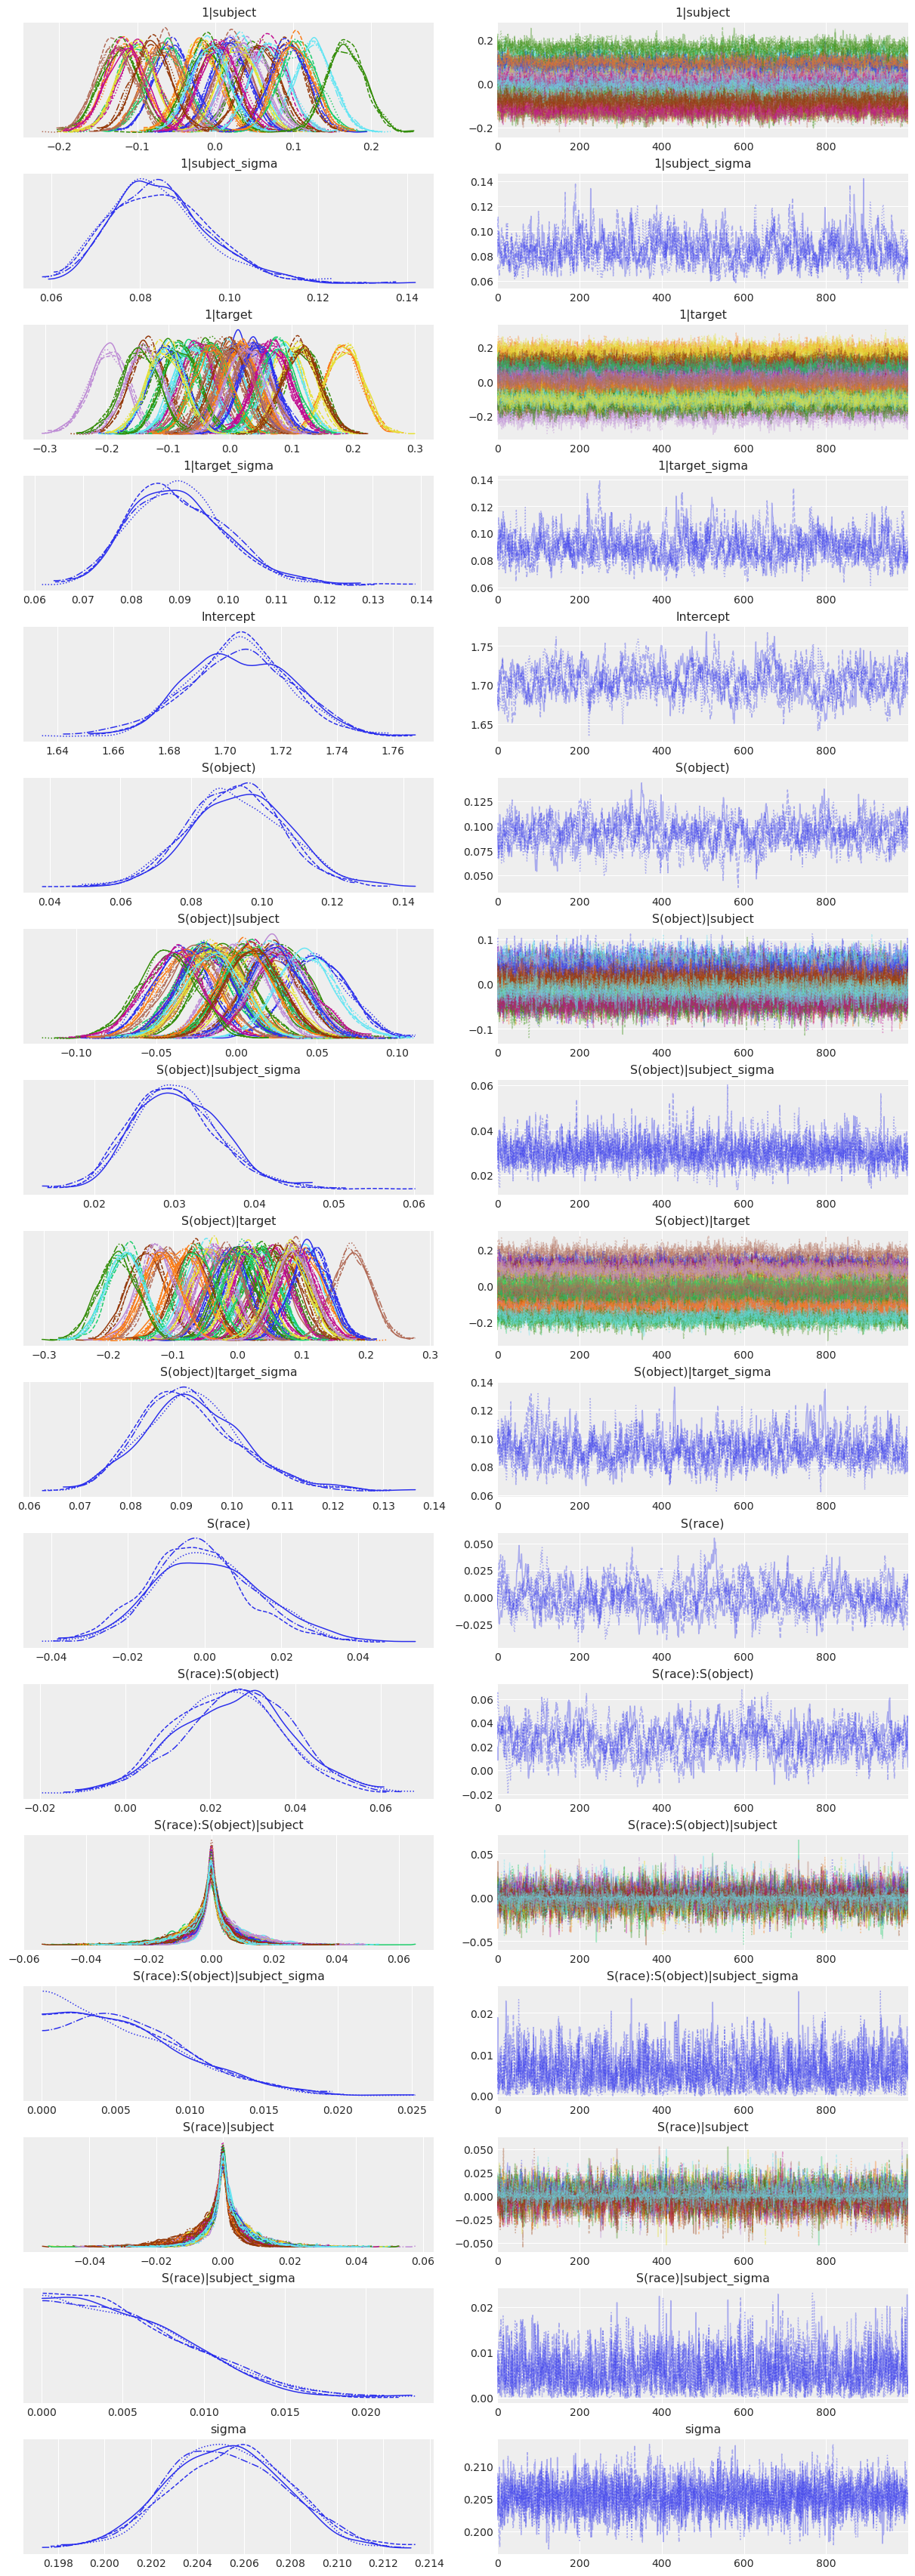

In [12]:
az.plot_trace(stim_fitted);

In [13]:
az.summary(stim_fitted)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
1|subject[1]                 -0.005  0.024  -0.049    0.041      0.001   
1|subject[2]                 -0.068  0.024  -0.116   -0.025      0.001   
1|subject[3]                  0.049  0.025   0.005    0.098      0.001   
1|subject[4]                  0.069  0.024   0.024    0.112      0.001   
1|subject[5]                  0.001  0.024  -0.043    0.049      0.001   
...                             ...    ...     ...      ...        ...   
S(race)|subject[black, 34]   -0.001  0.006  -0.014    0.011      0.000   
S(race)|subject[black, 35]   -0.002  0.007  -0.015    0.010      0.000   
S(race)|subject[black, 36]    0.001  0.007  -0.011    0.015      0.000   
S(race)|subject_sigma[black]  0.006  0.004   0.000    0.013      0.000   
sigma                         0.205  0.003   0.201    0.210      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
1|subject[1]                    0.001     870.0    1909.0    1.0  
1|subject[2]                    0.001     892.0    2063.0    1.0  
1|subject[3]                    0.001     756.0    1698.0    1.0  
1|subject[4]                    0.001     717.0    1633.0    1.0  
1|subject[5]                    0.001     912.0    1777.0    1.0  
...                               ...       ...       ...    ...  
S(race)|subject[black, 34]      0.000    4256.0    3220.0    1.0  
S(race)|subject[black, 35]      0.000    3643.0    3159.0    1.0  
S(race)|subject[black, 36]      0.000    4687.0    3272.0    1.0  
S(race)|subject_sigma[black]    0.000    1238.0    1127.0    1.0  
sigma                           0.000    3101.0    3092.0    1.0  

[255 rows x 9 columns]

There are two interesting things to note here. The first is that the key interaction effect, ```S(race):S(object)``` is much less clear now. The marginal posterior is still mostly concentrated away from 0, but there’s certainly a nontrivial part that overlaps with 0; 2.9% of the distribution, to be exact.

In [14]:
(stim_fitted.posterior["S(race):S(object)"] < 0).mean()

<xarray.DataArray 'S(race):S(object)' ()> Size: 8B
array(0.02625)

The second interesting thing is that the two new variance components in the model, those associated with the stimulus specific effects, are actually rather large. This actually largely explains the first fact above, since if these where estimated to be close to 0 anyway, the model estimates wouldn’t be much different than they were in the ```subj_model```. It makes sense that there is a strong tendency for different targets to elicit difference reaction times on average, which leads to a large estimate of ```1|target_sigma```.

Less obviously, the large estimate of ```S(object)|target_sigma``` (targets tend to vary a lot in their response rate differences when they have a gun vs. some other object) also makes sense, because in this experiment, different targets were pictured with different non-gun objects. Some of these objects, such as a bright red can of Coca-Cola, are not easily confused with a gun, so subjects are able to quickly decide on the correct response. Other objects, such as a black cell phone, are possibly easier to confuse with a gun, so subjects take longer to decide on the correct response when confronted with this object.

Since each target is yoked to a particular non-gun object, there is good reason to expect large target-to-target variability in the ```object``` effect, which is indeed what we see in the model estimates.

## Fit response models

Here we seek evidence of the second traditional finding, that subjects are more likely to response ‘shoot’ toward black targets than toward white targets, regardless of whether they are armed or not. Currently the dataset just records whether the given response was correct or not, so first we transformed this into whether the response was ‘shoot’ or ‘dontshoot’.

In [15]:
shooter["shoot_or_not"] = shooter["response"].astype(str)

# armed targets
new_values = {"correct": "shoot", "incorrect": "dontshoot", "timeout": np.nan}
shooter.loc[shooter["object"] == "gun", "shoot_or_not"] = (
    shooter.loc[shooter["object"] == "gun", "response"].astype(str).replace(new_values)
)
    
# unarmed targets
new_values = {"correct": "dontshoot", "incorrect": "shoot", "timeout": np.nan}
shooter.loc[shooter["object"] == "nogun", "shoot_or_not"] = (
    shooter.loc[shooter["object"] == "nogun", "response"].astype(str).replace(new_values)
)
    
# view result
shooter.head(20)

subject target  trial   race object   time   response      rate  \
0         1    w05     19  white  nogun  658.0    correct  1.519757   
1         2    b07     19  black    gun  573.0    correct  1.745201   
2         3    w05     19  white    gun  369.0    correct  2.710027   
3         4    w07     19  white    gun  495.0    correct  2.020202   
4         5    w15     19  white  nogun  483.0    correct  2.070393   
5         6    w96     19  white  nogun  786.0    correct  1.272265   
6         7    w13     19  white  nogun  519.0    correct  1.926782   
7         8    w06     19  white  nogun  567.0    correct  1.763668   
8         9    b14     19  black    gun  672.0  incorrect  1.488095   
9        10    w90     19  white    gun  457.0    correct  2.188184   
10       11    w91     19  white  nogun  599.0    correct  1.669449   
11       12    b17     19  black  nogun  769.0    correct  1.300390   
12       13    b04     19  black  nogun  600.0    correct  1.666667   
13       14    w17     19  white  nogun  653.0    correct  1.531394   
14       15    b93     19  black    gun  468.0    correct  2.136752   
15       16    w96     19  white    gun  546.0    correct  1.831502   
16       17    w91     19  white    gun  591.0  incorrect  1.692047   
17       18    b95     19  black    gun    NaN    timeout       NaN   
18       19    b09     19  black    gun  656.0    correct  1.524390   
19       20    b02     19  black    gun  617.0    correct  1.620746   

   shoot_or_not  
0     dontshoot  
1         shoot  
2         shoot  
3         shoot  
4     dontshoot  
5     dontshoot  
6     dontshoot  
7     dontshoot  
8     dontshoot  
9         shoot  
10    dontshoot  
11    dontshoot  
12    dontshoot  
13    dontshoot  
14        shoot  
15        shoot  
16    dontshoot  
17          NaN  
18        shoot  
19        shoot

Let’s skip straight to the correct model that includes stimulus specific effects. This looks quite similiar to the ```stim_model``` from above except that we change the response to the new ```shoot_or_not variable``` – notice the [```shoot```] syntax indicating that we wish to model the prbability that ```shoot_or_not=='shoot'```, not ```shoot_or_not=='dontshoot'``` – and then change to ```family='bernoulli'``` to indicate a mixed effects logistic regression.

In [16]:
stim_response_model = bmb.Model(
    "shoot_or_not[shoot] ~ S(race)*S(object) + (S(race)*S(object) | subject) + (S(object) | target)",
    shooter,
    family="bernoulli",
    dropna=True
)

# Note we increased target_accept from default 0.8 to 0.9 because there were divergences
stim_response_fitted = stim_response_model.fit(
    draws=2000, 
    target_accept=0.9,
    random_seed=SEED
)

Automatically removing 98/3600 rows from the dataset.
Modeling the probability that shoot_or_not==shoot
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, S(race), S(object), S(race):S(object), 1|subject_sigma, 1|subject_offset, S(race)|subject_sigma, S(race)|subject_offset, S(object)|subject_sigma, S(object)|subject_offset, S(race):S(object)|subject_sigma, S(race):S(object)|subject_offset, 1|target_sigma, 1|target_offset, S(object)|target_sigma, S(object)|target_offset]


c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 290 seconds.


Show the trace plot

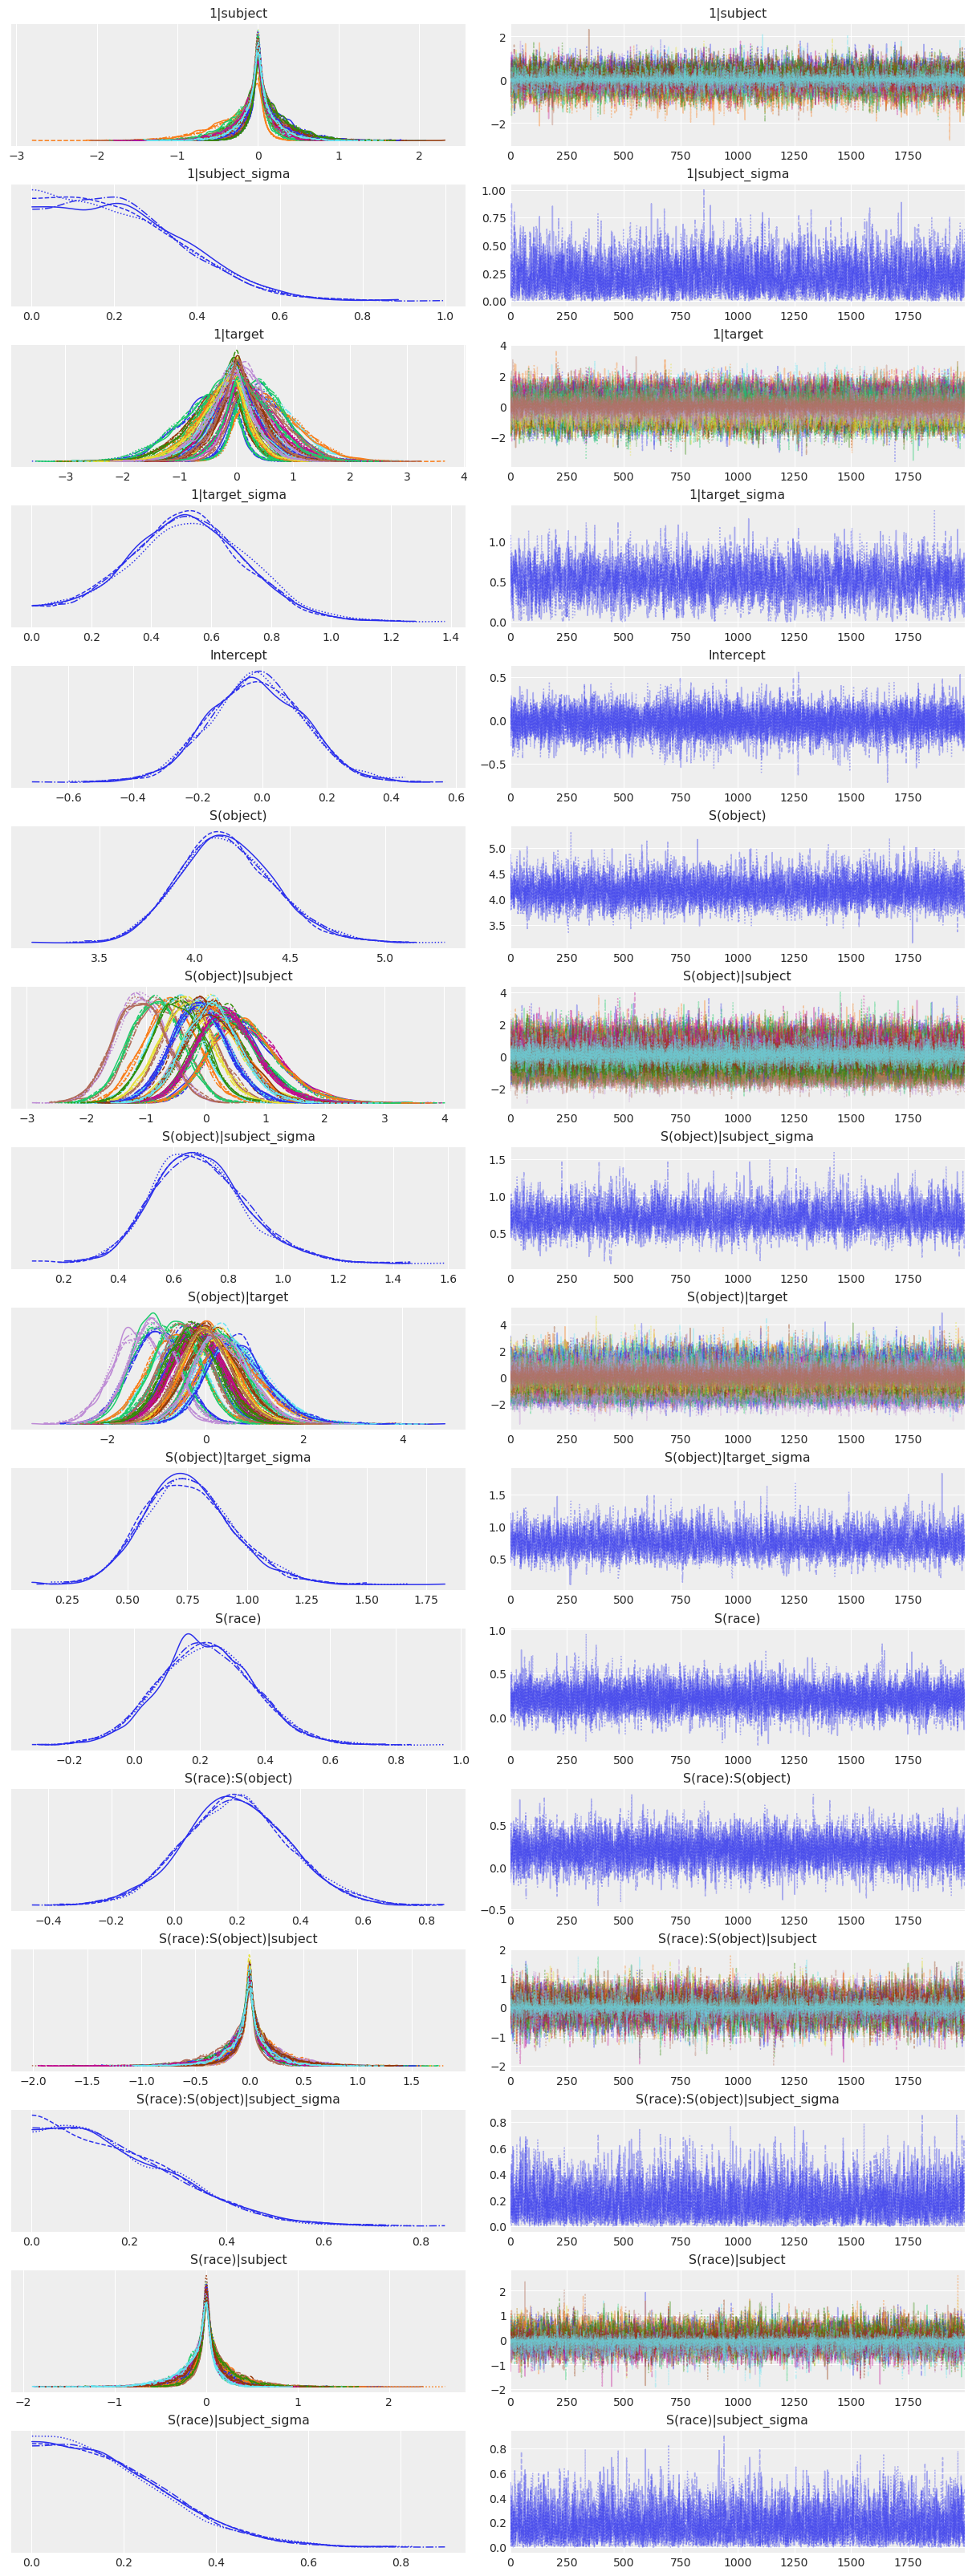

In [17]:
az.plot_trace(stim_response_fitted);

Looks pretty good! Now for the more concise summary.

In [18]:
az.summary(stim_response_fitted)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
1|subject[1]                 -0.003  0.241  -0.496    0.482      0.002   
1|subject[2]                 -0.057  0.254  -0.623    0.391      0.002   
1|subject[3]                 -0.106  0.258  -0.668    0.327      0.003   
1|subject[4]                 -0.000  0.249  -0.518    0.493      0.002   
1|subject[5]                  0.056  0.239  -0.400    0.550      0.002   
...                             ...    ...     ...      ...        ...   
S(race)|subject[black, 33]    0.087  0.216  -0.278    0.546      0.002   
S(race)|subject[black, 34]   -0.055  0.214  -0.526    0.326      0.002   
S(race)|subject[black, 35]   -0.021  0.214  -0.453    0.408      0.002   
S(race)|subject[black, 36]   -0.096  0.227  -0.556    0.307      0.002   
S(race)|subject_sigma[black]  0.184  0.134   0.000    0.423      0.002   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
1|subject[1]                    0.003   13378.0    6383.0    1.0  
1|subject[2]                    0.003   12064.0    6345.0    1.0  
1|subject[3]                    0.002    9316.0    6876.0    1.0  
1|subject[4]                    0.003   13779.0    6708.0    1.0  
1|subject[5]                    0.002   13026.0    6545.0    1.0  
...                               ...       ...       ...    ...  
S(race)|subject[black, 33]      0.002   10528.0    6105.0    1.0  
S(race)|subject[black, 34]      0.002   12473.0    6429.0    1.0  
S(race)|subject[black, 35]      0.002   11644.0    6395.0    1.0  
S(race)|subject[black, 36]      0.002   10058.0    5852.0    1.0  
S(race)|subject_sigma[black]    0.001    4168.0    4686.0    1.0  

[254 rows x 9 columns]

There is some slight evidence here for the hypothesis that subjects are more likely to shoot the black targets, regardless of whether they are armed or not, but the evidence is not too strong. The marginal posterior for the S(race) coefficient is mostly concentrated away from 0, but it overlaps even more in this case with 0 than did the key interaction effect in the previous model.

In [19]:
(stim_response_fitted.posterior["S(race)"] < 0).mean()

<xarray.DataArray 'S(race)' ()> Size: 8B
array(0.059875)

In [20]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Oct 29 2024

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.26.0

arviz     : 0.19.0
numpy     : 1.26.4
bambi     : 0.14.0
matplotlib: 3.9.1
pandas    : 2.2.2

Watermark: 2.4.3

